In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
cd drive/MyDrive/Image Captioning

[Errno 2] No such file or directory: 'drive/MyDrive/Image Captioning'
/content/drive/MyDrive/Image Captioning


In [21]:
ls

caption.py        model_12.h5  model_19.h5  model_6.h5
descriptions.txt  model_13.h5  model_1.h5   model_7.h5
features.pkl      model_14.h5  model_20.h5  model_8.h5
Flickr8k_text/    model_15.h5  model_2.h5   model_9.h5
model_0.h5        model_16.h5  model_3.h5   model.png
model_10.h5       model_17.h5  model_4.h5   pexels-rene-asmussen-25763.jpg
model_11.h5       model_18.h5  model_5.h5   tokenizer.pkl


In [50]:
# tensorflow version
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras version
import keras
print('keras: %s' % keras.__version__)
print(tensorflow.test.gpu_device_name())

from os import listdir
import numpy as np
from pickle import dump
from pickle import load
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image 

tensorflow: 2.5.0
keras: 2.5.0



In [51]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34

In [52]:
# load the model
model = load_model('model_20.h5')

In [53]:
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# load and prepare the photograph
photo = extract_features('example.jpg')

In [54]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [55]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

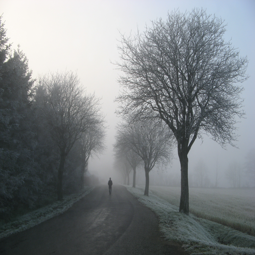

In [57]:
im = Image.open(r'example.jpg')
im = im.resize((255, 255))
im

In [56]:
description = generate_desc(model, tokenizer, photo, max_length)
sentence = description.split()
sentence = sentence[1:-1]
caption = ' '.join([str(e) for e in sentence]) 
caption


'man is riding bike on dirt trail'